#### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch

In [2]:
def do_seed():
    RANDOM_SEED = 50
    np.random.seed(RANDOM_SEED)
    torch.manual_seed(RANDOM_SEED)
    return 

#### encoding 4 bits into one hot 

In [3]:
def encod_map(x):
    e = np.zeros(16).astype(int)
    index = int("".join(str(y) for y in x), 2)
    e[index] = 1
    return  e

In [4]:
l = [1,0,0,1]
encod_l = encod_map(l)
print(encod_l)

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


#### train_test_split

In [5]:
do_seed()
X = np.random.randint(1,10,size=(10000,4))%2

In [6]:
Y = np.mean(X,axis = 1)

In [7]:
x_train,x_test = train_test_split(X,test_size=0.2,random_state=4,stratify=Y)

In [8]:
x_train.shape

(8000, 4)

In [9]:
x_test.shape

(2000, 4)

In [10]:
x_new_train = np.zeros((x_train.shape[0],2**(x_train.shape[1])))
for i in range(x_train.shape[0]):
    x_new_train[i] = encod_map(x_train[i])

In [11]:
x_new_test = np.zeros((x_test.shape[0],2**(x_test.shape[1])))
for i in range(x_test.shape[0]):
    x_new_test[i] = encod_map(x_test[i])

In [12]:
print(np.where(np.sum(x_new_train,axis=1) != 1))
print(np.where(np.sum(x_new_test,axis=1) != 1))

(array([], dtype=int64),)
(array([], dtype=int64),)


In [13]:
x_torch_train = torch.from_numpy(x_new_train).float()
x_torch_test = torch.from_numpy(x_new_test).float()

In [14]:
batch = 100

In [15]:
do_seed()
train_loader = DataLoader(x_torch_train,batch_size = batch,shuffle = True)
test_loader = DataLoader(x_new_test,batch_size = batch,shuffle = False)

#### Autoencoder Class

In [16]:
class Autoencoder(nn.Module):
    def __init__(self, in_sz = 16, out_sz = 16, layers=[7]):
        super().__init__()
        self.layer1 = nn.Linear(in_sz,layers[0])
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(layers[0],out_sz)
        self.softmax = nn.Softmax()

    def forward(self,X,var = 0):
        out1 = self.relu(self.layer1(X))
        self.out_bef_noise = out1
        self.encoded_sig = self.normalize(self.out_bef_noise)
        self.encoded_sig = self.add_noise( self.encoded_sig,var)
        # self.encoded_sig = self.normalize(self.encoded_sig)
        out = self.softmax(self.layer2(self.encoded_sig))
        self.output = out
        return out
    
    def encoded_msg(self):
        return self.out_bef_noise,self.encoded_sig
    
    def add_noise(self,msg,var):
        # torch.manual_seed(50)
        msg = msg + (var ** 0.5)*torch.randn(msg.size())
        return msg
    
    def normalize(self,sig):
        norm = torch.zeros(sig.size()[0],1)
        norm[:,0] = (torch.linalg.norm(sig,dim = 1))
        norm = norm.expand(-1,sig.size()[1])
        sig = torch.div(sig,norm)
        sig = sig * 7
        return sig

#### Model

In [17]:
do_seed()
model = Autoencoder()
model

Autoencoder(
  (layer1): Linear(in_features=16, out_features=7, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=7, out_features=16, bias=True)
  (softmax): Softmax(dim=None)
)

In [18]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [19]:
do_seed()
import time
start_time = time.time()

epochs = 50
train_losses = []
test_losses = []
train_correct = []
test_correct = []

fp = open('output_1hd.txt',"w")
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    

    for b,x in enumerate(train_loader):

        b+=1

        y_pred = model(x.view(batch,-1))
        pred_index = torch.argmax(y_pred,dim = 1)
        actual_index = torch.argmax(x,dim = 1)
        
        loss = criterion(y_pred, actual_index)
 
        batch_corr = torch.sum(pred_index == actual_index)
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if b%20 == 0:
            fp.write(f'epoch: {i}  batch: {b} [{batch*b:6}/{x_train.shape[0]}]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(batch*b):7.3f}%')
            fp.write('\n')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr)

    with torch.no_grad():
        for test in test_loader:

            y_val = model(test.view(batch, -1).float())

            predicted_test = torch.argmax(y_val,dim = 1)
            actual_test = torch.argmax(test,dim = 1)
            
            tst_corr += torch.sum(predicted_test == actual_test)
    
    loss = criterion(y_val, actual_test)
    test_losses.append(loss.item())
    test_correct.append(tst_corr)

fp.close()
fp = open('output_1hd.txt',"a")
fp.write(f'\nDuration: {time.time() - start_time:.0f} seconds')
fp.close()  # ouput written on output.txt

/home/lohith/chida/environments/basic/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
/home/lohith/chida/environments/basic/lib/python3.7/site-packages/torch/autograd/__init__.py:175: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


#### Decoding one hot into 4 bit

In [20]:
def decod_map(e):
    e = e.numpy().astype(int)
    print(e)
    i = int(np.where(e == 1)[0])
    ls = list(bin(i).replace("0b",""))
    if len(ls) != 4:
        ls = [0]*abs(len(ls)-4) + ls
    return np.array(ls).astype(int)

#### plots

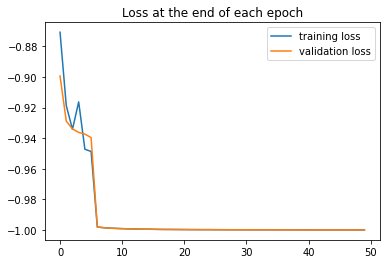

In [21]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [22]:
print(x_train.shape[0],x_test.shape[0])

8000 2000


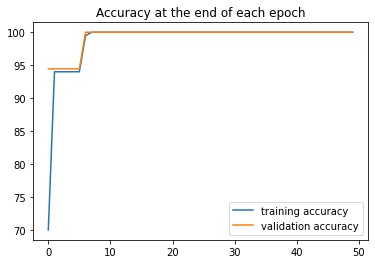

In [23]:
plt.plot([(t*100)/x_train.shape[0] for t in train_correct], label='training accuracy')
plt.plot([(t*100)/x_test.shape[0] for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [24]:
print(f'Test accuracy: {test_correct[-1].item()*100/(x_test.shape[0]):.3f}%')

Test accuracy: 100.000%


#### impact of varience of the noise on accuracy

In [25]:
def cal_accuracy(var,fp,epochs = 150):
    do_seed()

    train_losses_var = []
    test_losses_var = []
    train_correct_var = []
    test_correct_var = []

    for i in range(epochs):
        trn_corr = 0
        tst_corr = 0
        
        for b,x in enumerate(train_loader):

            b+=1

            y_pred = model(x.view(batch,-1))
            pred_index = torch.argmax(y_pred,dim = 1)
            actual_index = torch.argmax(x,dim = 1)
            
            loss = criterion(y_pred, actual_index)
    
            batch_corr = torch.sum(pred_index == actual_index)
            trn_corr += batch_corr

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        

        train_losses_var.append(loss.item())
        train_correct_var.append(trn_corr)

        with torch.no_grad():
            for x_test in test_loader:

                y_val = model(x_test.view(batch, -1).float())

                predicted_test = torch.argmax(y_val,dim = 1)
                actual_test = torch.argmax(x_test,dim = 1)
            
                tst_corr += torch.sum(predicted_test == actual_test)
        
        loss = criterion(y_val, actual_test)
        test_losses_var.append(loss.item())
        test_correct_var.append(tst_corr)

    fp.write(f'accuracy for the given {var} of noise after {epochs} epochs is {(train_correct_var[-1] * 100)/x_train.shape[0]}')
    fp.write('\n')
    return (train_correct_var[-1] * 100)/x_train.shape[0]

In [26]:
def run_model(var,fp):
    do_seed()
    return cal_accuracy(var,fp,150)

In [27]:
fp = open("varience_impact.txt",'w')
fp.close()
fp = open("varience_impact.txt",'a')
accuracy_varience = []
for var in range(1,10):
    accuracy_varience.append(run_model(var,fp))
fp.close()

/home/lohith/chida/environments/basic/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


In [28]:
accuracy_varience

[tensor(100.),
 tensor(100.),
 tensor(100.),
 tensor(100.),
 tensor(100.),
 tensor(100.),
 tensor(100.),
 tensor(100.),
 tensor(100.)]

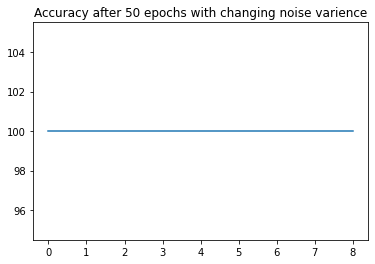

In [29]:
plt.plot(accuracy_varience)
plt.title('Accuracy after 50 epochs with changing noise varience')
plt.show();

#### model with two hidden layers

In [30]:
class change_layers_2hd(nn.Module):
    def __init__(self, in_sz = 16, out_sz = 16, layers=[7,7]):
        super().__init__()
        self.layer1 = nn.Linear(in_sz,layers[0])
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(layers[0],layers[1])
        self.relu = nn.ReLU()
        self.layer3 = nn.Linear(layers[1],out_sz)
        self.logsoftmax = nn.LogSoftmax()

    def forward(self,X,var = 0):
        out1 = self.relu(self.layer1(X))
        out2 = self.relu(self.layer2(out1))
        self.out_bef_noise = out2
        self.encoded_sig = self.normalize(self.out_bef_noise)
        self.encoded_sig = self.add_noise(self.encoded_sig,var)
        # self.encoded_sig = self.normalize(self.encoded_sig)
        out = self.logsoftmax(self.layer3(self.encoded_sig))
        self.output = out
        return out
    
    def encoded_msg(self):
        return self.out_bef_noise,self.encoded_sig
    
    def add_noise(self,msg,var):
        # torch.manual_seed(50)
        msg = msg + (var ** 0.5)*torch.randn(msg.size())
        return msg
    
    def normalize(self,sig):
        norm = torch.zeros(sig.size()[0],1)
        norm[:,0] = (torch.linalg.norm(sig,dim = 1))
        norm = norm.expand(-1,sig.size()[1])
        sig = torch.div(sig,norm)
        sig = sig * 7
        return sig

In [31]:
do_seed()
model_with_2hd = change_layers_2hd(layers = [7,7])
model_with_2hd

change_layers_2hd(
  (layer1): Linear(in_features=16, out_features=7, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=7, out_features=7, bias=True)
  (layer3): Linear(in_features=7, out_features=16, bias=True)
  (logsoftmax): LogSoftmax(dim=None)
)

In [38]:
do_seed()
import time
start_time = time.time()

epochs = 50
train_losses_2hd = []
test_losses_2hd = []
train_correct_2hd = []
test_correct_2hd = []

fp = open('output_2hd.txt',"w")
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    

    for b,x in enumerate(train_loader):

        b+=1

        y_pred = model_with_2hd(x.view(batch,-1))
        pred_index = torch.argmax(y_pred,dim = 1)
        actual_index = torch.argmax(x,dim = 1)
            
        loss = criterion(y_pred, actual_index)
    
        batch_corr = torch.sum(pred_index == actual_index)
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if b%20 == 0:
            fp.write(f'epoch: {i}  batch: {b} [{batch*b:6}/{x_train.shape[0]}]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(batch*b):7.3f}%')
            fp.write('\n')
        
    train_losses_2hd.append(loss.item())
    train_correct_2hd.append(trn_corr)

    with torch.no_grad():
        for test in test_loader:

            y_val = model_with_2hd(test.view(batch, -1).float())

            predicted_test = torch.argmax(y_val,dim = 1)
            actual_test = torch.argmax(test,dim = 1)
            
            tst_corr += torch.sum(predicted_test == actual_test)
    
    loss = criterion(y_val, actual_test)
    test_losses_2hd.append(loss.item())
    test_correct_2hd.append(tst_corr)

fp.close()
fp = open('output_2hd.txt',"a")
fp.write(f'\nDuration: {time.time() - start_time:.0f} seconds')
fp.close()  # ouput written on output.txt

/home/lohith/chida/environments/basic/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


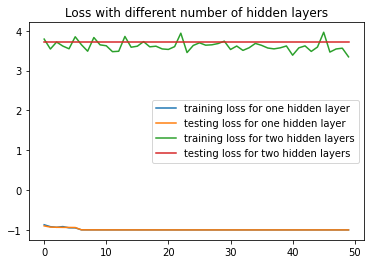

In [39]:
plt.plot(train_losses, label='training loss for one hidden layer')
plt.plot(test_losses, label='testing loss for one hidden layer')
plt.plot(train_losses_2hd, label='training loss for two hidden layers')
plt.plot(test_losses_2hd, label='testing loss for two hidden layers')
plt.title('Loss with different number of hidden layers')
plt.legend();

#### model with three hidden layers

In [45]:
class change_layers_3hd(nn.Module):
    def __init__(self, in_sz = 16, out_sz = 16, layers=[7,7,7]):
        super().__init__()
        self.layer1 = nn.Linear(in_sz,layers[0])
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(layers[0],layers[1])
        self.relu = nn.ReLU()
        self.layer3 = nn.Linear(layers[1],layers[2])
        self.relu = nn.ReLU()
        self.layer4 = nn.Linear(layers[2],out_sz)
        self.logsoftmax = nn.LogSoftmax()

    def forward(self,X,var = 0):
        out1 = self.relu(self.layer1(X))
        out2 = self.relu(self.layer2(out1))
        self.out_bef_noise = out2
        self.out_bef_noise = self.normalize(self.out_bef_noise)
        self.encoded_sig = self.add_noise(self.out_bef_noise,var)
        # self.encoded_sig = self.normalize(self.encoded_sig)
        self.encoded_sig = self.relu(self.layer3(self.encoded_sig))
        out = self.logsoftmax(self.layer4(self.encoded_sig))
        self.output = out
        return out
    
    def encoded_msg(self):
        return self.out_bef_noise,self.encoded_sig
    
    def add_noise(self,msg,var = 1):
        # torch.manual_seed(50)
        msg = msg + (var ** 0.5)*torch.randn(msg.size())
        return msg
    
    def normalize(self,sig):
        norm = torch.zeros(sig.size()[0],1)
        norm[:,0] = (torch.linalg.norm(sig,dim = 1))
        norm = norm.expand(-1,sig.size()[1])
        sig = torch.div(sig,norm)
        sig = sig * 7
        return sig

In [46]:
do_seed()
model_with_3hd = change_layers_3hd(layers = [7,7,7])
model_with_3hd

change_layers_3hd(
  (layer1): Linear(in_features=16, out_features=7, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=7, out_features=7, bias=True)
  (layer3): Linear(in_features=7, out_features=7, bias=True)
  (layer4): Linear(in_features=7, out_features=16, bias=True)
  (logsoftmax): LogSoftmax(dim=None)
)

In [47]:
do_seed()
import time
start_time = time.time()

epochs = 50
train_losses_3hd = []
test_losses_3hd = []
train_correct_3hd = []
test_correct_3hd = []

fp = open('output_3hd.txt',"w")
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    

    for b,x in enumerate(train_loader):
        
        b+=1

        y_pred = model_with_3hd(x.view(batch,-1))
        pred_index = torch.argmax(y_pred,dim = 1)
        actual_index = torch.argmax(x,dim = 1)
            
        loss = criterion(y_pred, actual_index)
    
        batch_corr = torch.sum(pred_index == actual_index)
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if b%20 == 0:
            fp.write(f'epoch: {i}  batch: {b} [{batch*b:6}/{x_train.shape[0]}]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(batch*b):7.3f}%')
            fp.write('\n')
        
    train_losses_3hd.append(loss.item())
    train_correct_3hd.append(trn_corr)

    with torch.no_grad():
        for test in test_loader:

            y_val = model_with_3hd(test.view(batch, -1).float())

            predicted_test = torch.argmax(y_val,dim = 1)
            actual_test = torch.argmax(test,dim = 1)
            
            tst_corr += torch.sum(predicted_test == actual_test)
    
    loss = criterion(y_val, actual_test)
    test_losses_3hd.append(loss.item())
    test_correct_3hd.append(tst_corr)

fp.close()
fp = open('output_3hd.txt',"a")
fp.write(f'\nDuration: {time.time() - start_time:.0f} seconds')
fp.close()  # ouput written on output.txt

/home/lohith/chida/environments/basic/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


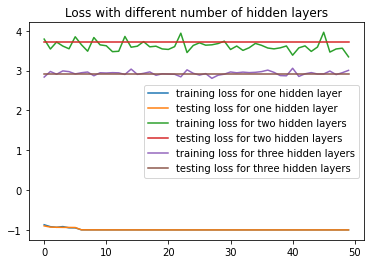

In [48]:
plt.plot(train_losses, label='training loss for one hidden layer')
plt.plot(test_losses, label='testing loss for one hidden layer')
plt.plot(train_losses_2hd, label='training loss for two hidden layers')
plt.plot(test_losses_2hd, label='testing loss for two hidden layers')
plt.plot(train_losses_3hd, label='training loss for three hidden layers')
plt.plot(test_losses_3hd, label='testing loss for three hidden layers')
plt.title('Loss with different number of hidden layers')
plt.legend();